In [1]:
# import required packages

import pandas as pd
import numpy as np
import time
import json
import os
import pickle
import datetime
import seaborn as sns
from monkeylearn import MonkeyLearn
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt


# Data Integration

- The dataset has various types of data spanning from app usage, to sensing data, and finally to user survey repsone data.
- To give a rough estimate, the dataset consists of about 300 CSV files, 150 JSON files and 60 TXT files. <br>
- We have integrated all of these data into a single dataframe with 35 features and 2 target variables.

In [57]:
'''
Initializing the dataframe with user IDs
'''

# total number of unique users
n = 60
# select the entire interval of 40 days for plotting the correlation heatmap
interval = 40

# start date of the dataset
start_date = datetime.datetime.strptime('Sun Mar 24 00:00:00 2013', "%a %b %d %H:%M:%S %Y")
# end date of the dataset
end_date = start_date + datetime.timedelta(days=interval)

# set options to display entire dataframe with all the rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

final_df = pd.DataFrame()
final_df['uid'] = ['u'+str(uid).zfill(len(str(n))) for uid in range(n)]  # zfill adds preceding zeros, e.g. u01 instead of u1


In [10]:
'''
The dataset includes a seperate CSV file for each user: running_app_u00.csv, running_app_u01.csv, etc.
We have classified each app into a category, and every category is considered as an individual feature.
This function gets the app usage data by combining each of the CSV file into various columns each referring a single category.
App usage data refers to the total number of times a user uses any app belonging to each category in the given interval.
Example of categories: social media, games, messaging, etc.

'''

def app_usage():
        
    apps_by_category = pd.read_csv('dataset_overview.csv')
    category_dict = {}
    category_count = {}

    for category in apps_by_category['Application Type Unique']:
        category_dict[category] = apps_by_category.loc[apps_by_category['Application Type']==category,
                                                       'RUNNING_TASKS_topActivity_mPackage']
        
        if len(category_dict[category])>0:
            category_dict[category] = category_dict[category].tolist()
    
    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        filename = '../dataset/app_usage/running_app_'+uid+'.csv'
        category_count = {}
        
        if os.path.isfile(filename):
            usage = pd.read_csv(filename)
            usage = usage.loc[(usage['timestamp']>=time.mktime(start_date.timetuple())) &
                             (usage['timestamp']>=time.mktime(end_date.timetuple()))]
            
            list_of_apps = usage['RUNNING_TASKS_topActivity_mPackage'].tolist()
            
            for i in category_dict.keys():
                category_count[i]=0
                
                for j in list_of_apps:
                    
                    if j in category_dict[i]:
                        category_count[i] += 1
                
                final_df.loc[final_df['uid']==uid, i] = int(category_count[i])
                

In [11]:
'''
The dataset includes seperate TXT file for each user: u00.txt, u01.txt, u02.txt, etc.
This function calculates the total number of times a user visits each restaurant and cafe in the given time interval.
Each dining place is considered as an individual feature.
Example of dining places: 53 Commons, Collis Cafe, Courtyard Cafe, etc.

'''

def dining():

    visits = {}
    present = []

    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        dining = ['King Arthur Flour Coffee Bar', '53 Commons', 'Collis Cafe', 'Courtyard Cafe', 'Collis Market', 'Novack Cafe']
        filename = '../dataset/dinning/'+uid+'.txt'
        
        # initialize the final_df with NaN values for each user and cafes
        for cafe in dining:
            final_df.loc[final_df['uid']==uid,cafe] = np.NaN
        
        # check if file exists in the directory
        if os.path.isfile(filename):
            file = open(filename)
            present.append(uid)  # dining data is available for this user with ID = uid
            
            for line in file:
                row = line.split(',')
                date = datetime.datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")
                
                if start_date < date < end_date:
                    dining.append(row[1])

            visits[str(uid).zfill(len(str(n)))] = dict(Counter(dining))

    
    for uid, dining in visits.items():
        for cafe, frequency in dining.items():
            if uid in present:
                # store the total number of visits at each restaurant by a particular user
                final_df.loc[final_df['uid']==uid,cafe] = int(frequency - 1)


In [12]:
'''
The dataset includes one CSV file consisting of all the users: piazza.csv
This function gets all the user's activity details such as total views on piazza, number of questions and answers posted, etc.
Each of these activity details is considered as an individual feature.

'''

def piazza():
    
    piazza_activity = pd.DataFrame()
    piazza_activity = pd.read_csv('../dataset/education/piazza.csv')

    for uid in piazza_activity['uid']:

        final_df.loc[final_df['uid']==uid,'Days online'] = int(piazza_activity.loc[piazza_activity['uid']==uid,'days online'].tolist()[0])
        final_df.loc[final_df['uid']==uid,'Views'] = int(piazza_activity.loc[piazza_activity['uid']==uid,'views'].tolist()[0])
        final_df.loc[final_df['uid']==uid,'Contributions'] = int(piazza_activity.loc[piazza_activity['uid']==uid,'contributions'].tolist()[0])
        final_df.loc[final_df['uid']==uid,'Questions'] = int(piazza_activity.loc[piazza_activity['uid']==uid,'questions'].tolist()[0])
        final_df.loc[final_df['uid']==uid,'Notes'] = int(piazza_activity.loc[piazza_activity['uid']==uid,'notes'].tolist()[0])
        final_df.loc[final_df['uid']==uid,'Answers'] = int(piazza_activity.loc[piazza_activity['uid']==uid,'answers'].tolist()[0])


In [13]:
'''
The dataset includes seperate CSV files for the comments provided by each user: Comment_u00.csv, Comment_u01.csv, etc.
This function retrieves all the comments given by each user and calculates 
their total count, which is included as a single feature in our dataframe.
It also determines the sentiment of each comment using MonkeyLearn library, 
which is included as another feature in our dataframe as 'comments positivity'.

'''

def comments():

    user_comments = {}  # all the comments written by each user for sentiment analyses
    total_comments = {}  # total number of comments written by each user

    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        filename = '../dataset/EMA/response/Comment/Comment_'+uid+'.json'

        if os.path.isfile(filename):
            with open(filename) as file:
                comments_dict = json.load(file)

                count = 0
                comments = []
                for item in comments_dict:
                    if 'comment' in item:
                        date = datetime.datetime.strptime(time.ctime(item['resp_time']), "%a %b %d %H:%M:%S %Y")
                        if start_date < date < end_date:
                            comments.append(item['comment'])
                            count += 1

                total_comments[uid] = count   

                comments_merged = ''
                for comment in comments:
                    comments_merged += comment + ' '

                user_comments[uid] = comments_merged

    '''
    The code below determines the sentiment of each comment provided by the user
    '''

    ml = MonkeyLearn('API_KEY')  # the API_KEY used here for sentiment analysis has been removed
    module_id = 'cl_Jx8qzYJh'
        
    for k, v in user_comments.items():
        res = ml.classifiers.classify(module_id, [v], sandbox=False)
        if res.result[0][0]['label']=='Positive' or res.result[0][0]['label']=='Neutral':
            comment_sentiments[k] = res.result[0][0]['probability']
        if res.result[0][0]['label']=='Negative':
            comment_sentiments[k] = float(1 - float(res.result[0][0]['probability']))
    
    for uid, count in total_comments.items():
        final_df.loc[final_df['uid']==uid, 'Total comments'] = int(count)
        final_df.loc[final_df['uid']==uid, 'Comments positivity'] = comment_sentiments[uid]


In [14]:
'''
The dataset includes seperate CSV files for each user: sms_u00.csv, sms_u01.csv, sms_u02.csv, etc.
This function determines daily number of message interactions done by each user, 
and stores this data as a single feature in the dataframe.

'''

def sms():
    count = 0
    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        filename = '../dataset/sms/sms_'+uid+'.csv'
        
        if os.path.isfile(filename):
            
            try:
                sms_df = pd.read_csv(filename, usecols=['timestamp'])
            except ValueError:
                final_df.loc[final_df['uid']==uid, 'SMS'] = np.NaN
                continue
            
            sms_df = sms_df.loc[(sms_df['timestamp'] >= time.mktime(start_date.timetuple())) &
                          (sms_df['timestamp'] < time.mktime(end_date.timetuple())), sms_df.columns]
            
            count = len(sms_df)
            
            final_df.loc[final_df['uid']==uid, 'SMS'] = round(count/interval, 2)


In [15]:
'''
The dataset includes seperate CSV files for each user: call_log_u00.csv, call_log_u01.csv, etc.
This function determines the average duration (in minutes) daily spent by the user 
on phone calls, which is stored as a single feature in the dataframe.

'''

def call():
    
    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        filename = '../dataset/call_log/call_log_'+uid+'.csv'
        
        if os.path.isfile(filename):
            
            try:
                call_df = pd.read_csv(filename, usecols=['timestamp', 'CALLS_duration'])
            except ValueError:
                final_df.loc[final_df['uid']==uid, 'Call duration'] = np.NaN
                continue
            
            call_df = call_df.loc[(call_df['timestamp'] >= time.mktime(start_date.timetuple())) &
                          (call_df['timestamp'] < time.mktime(end_date.timetuple())), call_df.columns]
            
            # remove the rows with null values
            call_df = call_df[pd.notnull(call_df['CALLS_duration'])]
            
            if call_df.size != 0:
                # average daily call duration of each user in minutes
                average = (float(sum(call_df['CALLS_duration'])/interval))/60
            else:
                average = 0

            final_df.loc[final_df['uid']==uid, 'Call duration'] = float("{0:.2f}".format(average))


In [16]:
'''
The dataset includes seperate CSV files for each user: conversation_u00.csv, conversation_u01.csv, etc.
This function determines the average time (in minutes) daily spent by the user on conversing with people,
and is stored as a single feature in our dataframe.

'''

def conversation():
    
    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        filename = '../dataset/sensing/conversation/conversation_'+uid+'.csv'

        if os.path.isfile(filename):

            conv_df = pd.read_csv(filename)
            conv_df = conv_df.loc[(conv_df['start_timestamp'] >= time.mktime(start_date.timetuple())) &
                          (conv_df['start_timestamp'] < time.mktime(end_date.timetuple())), conv_df.columns]
            
            conv_df['Conversation duration'] = conv_df[' end_timestamp'].sub(conv_df['start_timestamp'], axis=0)

            if conv_df['Conversation duration'].size != 0:
                # average daily conversation duration of each user in minutes
                average = (float(sum(conv_df['Conversation duration'])/interval))/60
            else:
                average = 0

            final_df.loc[final_df['uid']==uid, 'Conversation duration'] = float("{0:.2f}".format(average))


In [18]:
'''
The dataset includes a single CSV file for the deadline data: deadlines.csv
This functin retrives the total number of deadlines for each user in the given interval,
and stores it in our dataframe as a single feature.

'''

def deadlines():
    
    
    filename = '../dataset/education/deadlines.csv'
    df_deadlines = pd.read_csv(filename)
    
    # get column names
    columns = list(df_deadlines)
    
    for column in columns[1:]:
        date = datetime.datetime.strptime(column, "%Y-%m-%d")
        if not start_date < date < end_date:
            df_deadlines.drop([column], axis=1, inplace = True)
    
    # calculate the sum of total of number deadlines for each user
    df_deadlines['Total deadlines'] = df_deadlines.sum(axis=1)
    
    dict_deadlines = df_deadlines.set_index('uid')['Total deadlines'].to_dict()

    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        
        try:
            final_df.loc[final_df['uid']==uid, 'Total deadlines'] = int(dict_deadlines[uid])
        except:
            final_df.loc[final_df['uid']==uid, 'Total deadlines'] = np.NaN


In [19]:
'''
The dataset includes a single CSV file for GPA data: grades.csv
This function gets each user's grades -
1. Cumulative GPA
2. Current Spring Term's GPA at the time when this experiment was conducted
3. CS 65 class GPA, the course which initiated this experiment
This data is included in our dataframe as three seperate features: CGPA, Spring GPA, and CS65 GPA respectively.

'''

def grades():

    filename = '../dataset/education/grades.csv'
    df_grades = pd.read_csv(filename)

    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))

        cgpa = df_grades.loc[df_grades['uid']==uid, ' gpa all']
        gpa_spring = df_grades.loc[df_grades['uid']==uid, ' gpa 13s']
        gpa_cs65 = df_grades.loc[df_grades['uid']==uid, ' cs 65']

        if len(cgpa.index)>0:
            final_df.loc[final_df['uid']==uid, 'Cumulative GPA'] = float("{0:.2f}".format(cgpa.tolist()[0]))

        if len(gpa_spring.index)>0:
            final_df.loc[final_df['uid']==uid, 'Spring GPA'] = float("{0:.2f}".format(gpa_spring.tolist()[0]))

        if len(gpa_cs65.index)>0:
            final_df.loc[final_df['uid']==uid, 'CS65 GPA'] = float("{0:.2f}".format(gpa_cs65.tolist()[0]))


In [20]:
'''
The data includes seperate JSON files for each user: Sleep_u00.json, Sleep_u01.json, Sleep_u02.json, etc.
This function gets each user's following average sleep data -
1. sleep time per night
2. sleep rating for that night [1: Very Bad, 2: Bad, 3: Good, 4: Very Good]
3. number of times user had trouble staying awake during the following day [0: None, 1: Once, 2: Twice, 3: Three or more times]

'''

def sleep():
    
    for uid in range(n):
        uid = 'u'+str(uid).zfill(len(str(n)))
        
        filename = '../dataset/EMA/response/Sleep/Sleep_'+uid+'.json'
        
        if os.path.isfile(filename):
            sleep_total = 0
            sleep_rate_total = 0
            social_total = 0
            count = 0
            
            with open(filename) as file:
                sleep_dict_list = json.load(file)
                
            for sleep_dict in sleep_dict_list:
                
                if 'hour' in sleep_dict:
                    date = datetime.datetime.strptime(time.ctime(sleep_dict['resp_time']), "%a %b %d %H:%M:%S %Y")
                    
                    if start_date < date < end_date:
                        sleep_total += int(sleep_dict['hour']) 
                        sleep_rate_total += 5 - int(sleep_dict['rate'])
                        social_total += int(sleep_dict['social']) - 1
                        count += 1
        
            if count==0:
                average_sleep = 0.0
                average_sleep_rate = 0.0
                average_social = 0.0
    
            else:
                average_sleep = sleep_total/count
                average_sleep_rate = sleep_rate_total/count
                average_social = social_total/count
            
            final_df.loc[final_df['uid']==uid, 'Sleep Time'] = round(average_sleep, 2)
            final_df.loc[final_df['uid']==uid, 'Sleep Rating'] = round(average_sleep_rate, 2)
            final_df.loc[final_df['uid']==uid, 'Times Drowsy'] = round(average_social, 2)


In [21]:
'''
The dataset includes seperate JSON files for each user: Stress_u00.json, Stress_u01.json, Stress_u02.json, etc.
This function calculates the average stress level for each user.
[1: Feeling great, 2: Feeling good, 3: Little stressed, 4: Definitely stressed, 5: Stressed out]
This is included as the first target variable in our dataframe.

'''

def stress():

    for uid in range(n):

        stress = []
        uid = 'u'+str(uid).zfill(len(str(n)))
        filename = '../dataset/EMA/response/Stress/Stress_'+uid+'.json'

        # check if file exists in the directory
        if os.path.isfile(filename):
            with open(filename) as file:
                stress_dict = json.load(file)

                count = 0
                sum_stress_level = 0
                for item in stress_dict:
                    if 'level' in item:
                        date = datetime.datetime.strptime(time.ctime(item['resp_time']), "%a %b %d %H:%M:%S %Y")
                    
                        if start_date < date < end_date:
                            level = int(item['level'])
                            if level == 1: sum_stress_level += 3
                            elif level == 2: sum_stress_level += 4
                            elif level == 3: sum_stress_level += 5
                            elif level == 4: sum_stress_level += 2
                            elif level == 5: sum_stress_level += 1
                            count += 1

                if count == 0:
                    avg_stress_level = np.NaN
                else:
                    avg_stress_level = float("{0:.2f}".format(sum_stress_level/count))

                final_df.loc[final_df['uid']==uid, 'Stress Level'] = avg_stress_level

        else:
            final_df.loc[final_df['uid']==uid, 'Stress Level'] = np.NaN


In [22]:
'''
The dataset includes a single CSV file for that provides depression data.
This function calculates the depression frequency of each user, and is stored as our second target variable.

'''

def depression(period='post'):
    
    depression_frequency = {'Not at all': 0, 'Several days': 1, 'More than half the days': 2, 'Nearly every day': 3}
    
    df_depression = pd.read_csv('../dataset/survey/PHQ-9.csv')
    df_depression = df_depression.loc[df_depression['type']==period, df_depression.columns]
    
    for uid in df_depression['uid']:
        frequency_key = df_depression.loc[df_depression['uid']==uid, 'Feeling down, depressed, hopeless.'].tolist()[0]
        final_df.loc[final_df['uid']==uid, 'Depression Frequency'] = depression_frequency[frequency_key]


In [29]:
# call all of the above functions

sms()
call()
conversation()
deadlines()
grades()
sleep()
app_usage()
dining()
piazza()
comments()
stress()
depression()


In [31]:
'''
Converting the final dataframe into a csv file for further use, so that 
we don't have to repeatedly run the above functions for creating the dataframe.
'''

final_df.to_csv('sense_me.csv', index=False)


In [38]:
'''
Read the final.csv file from the local memory
'''

final_df = pd.read_csv('sense_me.csv')
final_df = final_df.set_index('uid')


# Data Cleaning

- The data is cleaned by filling the missing values.
- The features are numeric where they mostly represent frequency or duration.
- We cannot replace the missing values with 0 as it would be wrong to assume that a user has spent 0 minutes or the frequency is 0.
- We have analyzed various well known methods for data filling.
- The most logically and accurate way seems to fill the missing values with mean of that feature.

In [39]:
final_df = final_df.fillna(round(final_df.mean()))

final_df

,SMS,Call duration,Conversation duration,Total deadlines,Cumulative GPA,Spring GPA,CS65 GPA,Sleep Time,Sleep Rating,Times Drowsy,Academic,Books,Dating,Games,Health and Fitness,Mail,Maps,News,Puzzle,Travel,Movies and TV,King Arthur Flour Coffee Bar,53 Commons,Collis Cafe,Courtyard Cafe,Collis Market,Novack Cafe,Days online,Views,Contributions,Questions,Notes,Answers,Total comments,Comments positivity,Stress Level,Depression Frequency
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u00,23.68,7.88,394.53,11.0,3.00,3.00,4.00,6.28,2.87,0.08,240,0,0,0,0,2278,441,191,0,14,0,11.0,22.0,18.0,17.0,1.0,13.0,49,162,144,0,67,22,18,0.023,3.30,0
u01,23.85,9.00,436.08,5.0,2.86,1.78,3.00,7.22,3.41,0.85,0,0,0,1085,0,35,2,0,305,0,0,6.0,14.0,8.0,29.0,0.0,8.0,29,299,5,1,1,0,11,0.023,2.87,1
u02,42.10,1.57,319.32,7.0,3.50,4.00,4.00,7.64,2.91,0.32,40,27,0,186,0,1851,0,836,0,0,0,27.0,21.0,23.0,27.0,0.0,5.0,57,299,0,0,0,0,1,0.023,2.92,0
u03,23.02,9.00,80.86,10.0,3.00,3.00,4.00,7.56,3.32,0.12,0,0,0,0,0,0,0,0,0,0,0,11.0,22.0,18.0,17.0,1.0,13.0,47,262,30,15,2,6,3,0.023,2.50,1
u04,23.90,9.00,401.07,4.0,3.03,3.50,4.00,6.52,2.94,0.00,0,0,0,0,0,268,0,0,0,0,0,36.0,27.0,118.0,17.0,0.0,19.0,27,101,1,1,0,0,19,0.023,3.74,1
u05,23.75,9.00,294.90,9.0,3.68,3.78,4.00,7.50,3.50,0.50,0,0,0,0,0,303,0,0,0,0,0,8.0,25.0,45.0,14.0,5.0,14.0,67,301,1,0,0,0,2,0.023,2.12,0
u07,23.88,9.00,295.94,12.0,3.47,4.00,4.00,7.04,3.00,0.04,1,0,0,0,0,1025,0,0,0,0,0,0.0,22.0,0.0,39.0,0.0,0.0,43,201,12,1,0,0,9,0.025,2.23,1
u08,64.05,7.22,354.84,10.0,3.71,3.33,4.00,6.81,2.97,0.09,0,0,0,0,0,2628,976,0,0,0,0,23.0,11.0,33.0,28.0,5.0,13.0,67,308,45,22,0,5,35,0.023,3.63,1
u09,22.40,9.00,404.45,4.0,3.81,3.78,3.67,8.00,3.33,0.00,409,0,0,212,0,696,0,0,0,0,341,16.0,31.0,14.0,11.0,0.0,27.0,36,171,20,4,3,4,0,0.023,2.33,0


# Data Visualization

##### Plotting the correlation heatmaps between smartphone data and user's mental health

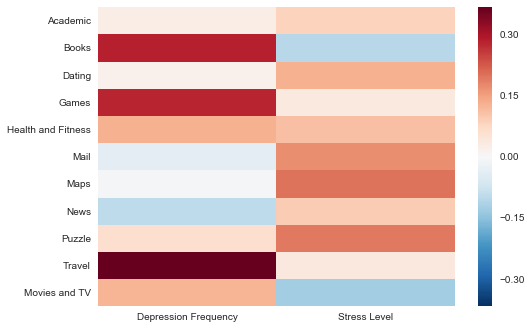

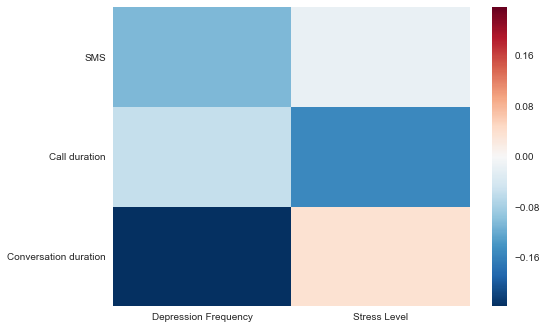

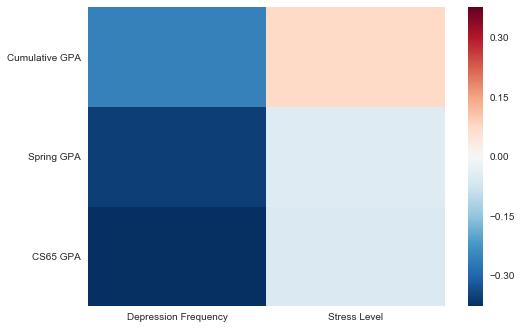

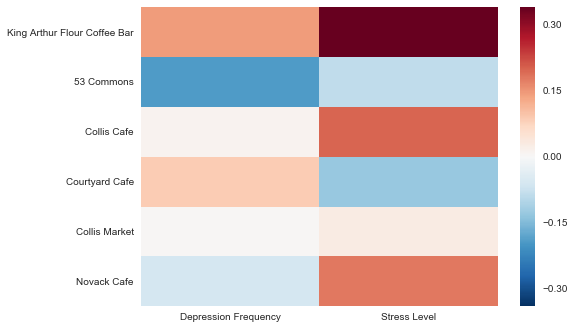

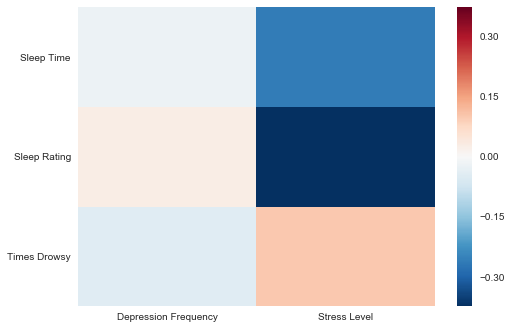

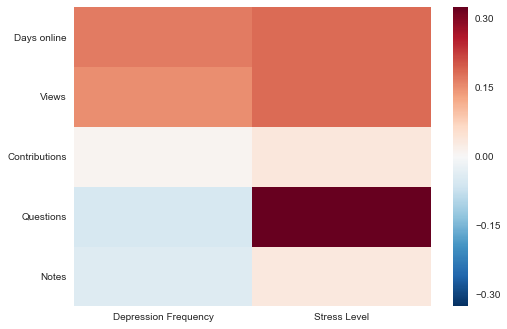

In [41]:
def sns_plot(label_list, label_list_2):
    corr = pd.DataFrame()
    for i in label_list_2:
        for j in label_list:
            corr.loc[i, j] = final_df.corr().loc[i, j]
    sns.heatmap(corr)
    

Apps = ['Academic', 'Books', 'Dating', 'Games', 'Health and Fitness', 'Mail', 'Maps', 'News', 
        'Puzzle', 'Travel', 'Movies and TV']

Social = ['SMS', 'Call duration', 'Conversation duration']

GPA = ['Cumulative GPA', 'Spring GPA', 'CS65 GPA']

Restaurants = ['King Arthur Flour Coffee Bar', '53 Commons', 'Collis Cafe', 'Courtyard Cafe', 'Collis Market', 'Novack Cafe']

Sleep = ['Sleep Time', 'Sleep Rating', 'Times Drowsy']

Piazza_Activity = ['Days online', 'Views', 'Contributions', 'Questions', 'Notes']

Target = ['Depression Frequency', 'Stress Level']

sns_plot(Target, Apps)
plt.yticks(rotation=0)
plt.show()

sns_plot(Target, Social)
plt.yticks(rotation=0)
plt.show()

sns_plot(Target, GPA)
plt.yticks(rotation=0)
plt.show()

sns_plot(Target, Restaurants)
plt.yticks(rotation=0)
plt.show()

sns_plot(Target, Sleep)
plt.yticks(rotation=0)
plt.show()

sns_plot(Target, Piazza_Activity)
plt.yticks(rotation=0)
plt.show()


Some analyses from above graphs:
- People who engage in long duration phone calls, read books, and / or watch Movies & TV are least stressed.
- Stressed people do not sleep for longer duration and are dissatisfied with their sleep.
- A stressed student asks lot of questions on Piazza.
- Students with less GPA experience high depression, and vice versa.
- People undergoing depression avoid interaction with people by not engaging much in phone calls, conversation, and SMS.
- Depressed people prefer playing games on their smartphones and reading books.
- It is fascinating to observe that there exists a correlation of both stress and depression with the dining place. Although the reason is uncertain and limited by dataset.

# Data Splitting

##### Increasing the number of users by splitting the dataset into several intervals of 5 days, and considering each interval as a new observation

In [72]:
'''
As we have time series data for each attribute, we have increased the number of users by splitting 
the dataset into several intervals of 5 days, and considered each interval as a new observation.
This is done by creating a new dataframe and calling the above funtions 10 times with the interval of 
5 days between start date and end date. This increases the total number of observations to 490 rows.

'''

frames_list = []
interval = 5
no_of_intervals = 10

end_date = start_date + datetime.timedelta(days=interval)

for i in range(no_of_intervals):
    final_df = pd.DataFrame()
    final_df['uid'] = ['u'+str(uid).zfill(len(str(n))) for uid in range(n)]
    
    sms()
    call()
    conversation()
    deadlines()
    grades()
    sleep()
    app_usage()
    dining()
    piazza()
    comments()
    stress()
    
    if i > 3:
        depression('post')
    else:
        depression('pre')

    frames_list.append(final_df)
    
    start_date = end_date
    end_date = start_date + datetime.timedelta(days=interval)

f_df = pd.concat(frames_list)

f_df = shuffle(f_df)
sense_df = f_df.reset_index(drop=True)


# Data Cleaning

In [74]:
'''
Clean the data by filling missing values with the mean value of that feature 
because of the same reason as mentioned earlier in this jupyter notebook.
NOTE: The dataframe displayed below now has 490 observations.

'''

sense_df = sense_df.fillna(round(sense_df.mean()))


sense_df


,SMS,Call duration,Conversation duration,Total deadlines,Cumulative GPA,Spring GPA,CS65 GPA,Sleep Time,Sleep Rating,Times Drowsy,Academic,Books,Dating,Games,Health and Fitness,Mail,Maps,Movies and TV,News,Puzzle,Travel,King Arthur Flour Coffee Bar,53 Commons,Collis Cafe,Courtyard Cafe,Collis Market,Novack Cafe,Days online,Views,Contributions,Questions,Notes,Answers,Total comments,Comments positivity,Stress Level,Depression Frequency
0,24.0,8.00,229.60,1.0,3.68,3.78,4.00,0.00,0.00,0.00,0,0,0,0,0,468,502,0,0,0,0,1.0,3.0,9.0,1.0,1.0,1.0,67,301,1,0,0,0,0,0.023,3.00,0.0
1,23.6,0.38,313.92,1.0,3.00,3.00,4.00,7.20,3.00,0.00,0,0,0,0,106,1977,285,137,4105,0,0,0.0,0.0,0.0,0.0,0.0,0.0,16,52,4,4,0,0,0,0.027,3.00,0.0
2,23.8,8.00,304.71,0.0,3.68,3.78,4.00,0.00,0.00,0.00,0,0,0,0,0,468,0,0,0,0,0,3.0,4.0,5.0,2.0,0.0,3.0,67,301,1,0,0,0,0,0.023,3.00,0.0
3,24.0,8.00,253.37,1.0,3.67,3.78,4.00,8.00,3.00,0.67,0,957,0,0,0,1331,1,0,0,0,0,0.0,7.0,0.0,7.0,0.0,1.0,82,300,26,11,0,3,0,0.023,2.17,0.0
4,45.0,3.17,182.34,5.0,3.62,3.78,4.00,5.75,3.00,1.25,176,0,0,0,0,2531,183,14,0,0,0,0.0,3.0,2.0,3.0,1.0,3.0,60,244,10,3,1,1,1,0.029,3.33,0.0
5,23.4,0.00,100.83,2.0,2.40,1.00,0.00,9.33,4.00,0.00,0,0,0,0,0,129,0,0,0,0,0,1.0,3.0,2.0,2.0,0.0,2.0,42,208,0,0,0,0,0,0.029,2.67,3.0
6,24.0,8.00,291.14,0.0,3.48,3.33,4.00,4.50,2.50,1.00,0,0,0,0,0,0,0,0,0,0,0,1.0,3.0,2.0,2.0,0.0,2.0,57,306,26,11,2,4,0,0.025,5.00,2.0
7,24.0,8.00,108.56,2.0,3.47,4.00,4.00,0.00,0.00,0.00,1,0,0,0,0,305,0,0,0,0,0,0.0,3.0,0.0,6.0,0.0,0.0,43,201,12,1,0,0,0,0.025,3.00,1.0
8,33.4,0.04,281.12,2.0,3.50,4.00,4.00,0.00,0.00,0.00,40,27,0,186,0,1851,0,0,836,0,0,5.0,3.0,3.0,2.0,0.0,3.0,57,299,0,0,0,0,0,0.023,4.00,0.0
9,24.0,0.00,290.29,1.0,3.00,3.00,4.00,0.00,0.00,0.00,0,0,0,0,0,669,285,137,2259,0,0,0.0,0.0,0.0,0.0,0.0,0.0,16,52,4,4,0,0,0,0.027,3.00,0.0


# Data Transformation

In [73]:
# Normalizing the values

features_df = sense_df.drop(['Stress Level'], axis=1)
features_df = features_df.drop(['Depression Frequency'], axis=1)

normalized_features = preprocessing.normalize(features_df)

X = pd.DataFrame(normalized_features, columns = features_df.columns)

X


,SMS,Call duration,Conversation duration,Total deadlines,Cumulative GPA,Spring GPA,CS65 GPA,Sleep Time,Sleep Rating,Times Drowsy,Academic,Books,Dating,Games,Health and Fitness,Mail,Maps,Movies and TV,News,Puzzle,Travel,King Arthur Flour Coffee Bar,53 Commons,Collis Cafe,Courtyard Cafe,Collis Market,Novack Cafe,Days online,Views,Contributions,Questions,Notes,Answers,Total comments,Comments positivity
0,0.030490,0.010163,0.291683,0.001270,0.004675,0.004802,0.005082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.594546,0.637739,0.000000,0.000000,0.000000,0.000000,0.001270,0.003811,0.011434,0.001270,0.001270,0.001270,0.085117,0.382389,0.001270,0.000000,0.000000,0.000000,0.000000,0.000029
1,0.005153,0.000083,0.068547,0.000218,0.000655,0.000655,0.000873,0.001572,0.000655,0.000000,0.000000,0.000000,0.000000,0.000000,0.023146,0.431695,0.062232,0.029915,0.896361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003494,0.011355,0.000873,0.000873,0.000000,0.000000,0.000000,0.000006
2,0.037274,0.012529,0.477217,0.000000,0.005763,0.005920,0.006265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.732952,0.000000,0.000000,0.000000,0.000000,0.000000,0.004698,0.006265,0.007831,0.003132,0.000000,0.004698,0.104931,0.471407,0.001566,0.000000,0.000000,0.000000,0.000000,0.000036
3,0.014216,0.004739,0.150084,0.000592,0.002174,0.002239,0.002369,0.004739,0.001777,0.000397,0.000000,0.566878,0.000000,0.000000,0.000000,0.788417,0.000592,0.000000,0.000000,0.000000,0.000000,0.000000,0.004146,0.000000,0.004146,0.000000,0.000592,0.048573,0.177705,0.015401,0.006516,0.000000,0.001777,0.000000,0.000014
4,0.017557,0.001237,0.071141,0.001951,0.001412,0.001475,0.001561,0.002243,0.001170,0.000488,0.068668,0.000000,0.000000,0.000000,0.000000,0.987490,0.071399,0.005462,0.000000,0.000000,0.000000,0.000000,0.001170,0.000780,0.001170,0.000390,0.001170,0.023409,0.095199,0.003902,0.001170,0.000390,0.000390,0.000390,0.000011
5,0.086894,0.000000,0.374424,0.007427,0.008912,0.003713,0.000000,0.034646,0.014854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.479031,0.000000,0.000000,0.000000,0.000000,0.000000,0.003713,0.011140,0.007427,0.007427,0.000000,0.007427,0.155964,0.772391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000108
6,0.056073,0.018691,0.680217,0.000000,0.008131,0.007780,0.009346,0.010514,0.005841,0.002336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002336,0.007009,0.004673,0.004673,0.000000,0.004673,0.133174,0.714935,0.060746,0.025700,0.004673,0.009346,0.000000,0.000058
7,0.062398,0.020799,0.282246,0.005200,0.009022,0.010400,0.010400,0.000000,0.000000,0.000000,0.002600,0.000000,0.000000,0.000000,0.000000,0.792972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007800,0.000000,0.015599,0.000000,0.000000,0.111796,0.522582,0.031199,0.002600,0.000000,0.000000,0.000000,0.000065
8,0.016042,0.000019,0.135021,0.000961,0.001681,0.001921,0.001921,0.000000,0.000000,0.000000,0.019212,0.012968,0.000000,0.089335,0.000000,0.889029,0.000000,0.000000,0.401528,0.000000,0.000000,0.002401,0.001441,0.001441,0.000961,0.000000,0.001441,0.027377,0.143609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011
9,0.010019,0.000000,0.121180,0.000417,0.001252,0.001252,0.001670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279272,0.118972,0.057190,0.943011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006679,0.021707,0.001670,0.001670,0.000000,0.000000,0.000000,0.000011


# Training & Evaluating the Regression model for Stress Level

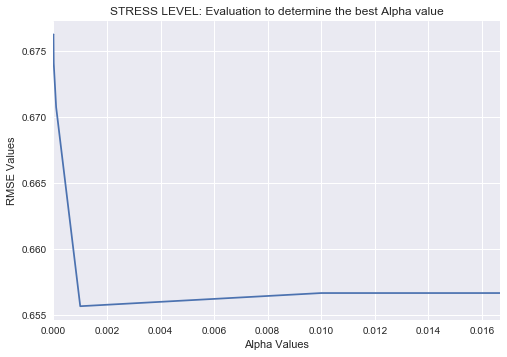

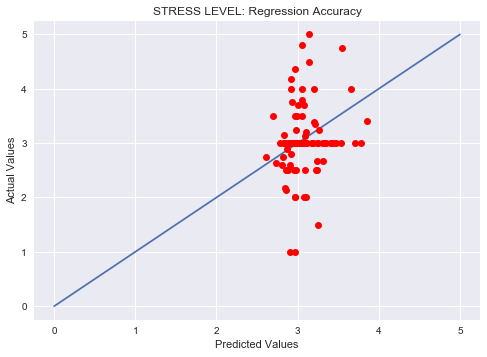

Target variable: Stress Level
Root Mean Squared Error: 0.6556



In [95]:
'''
Implemented linear regression with lasso regularization for feature selection
'''

labels = ['Stress Level']
alpha = [1e-25, 1e-20, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 100]
rmse_list = [[] for i in range(len(labels))]
error = {}
score = {}

for count, label in enumerate(labels):
    
    Y = sense_df[label]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
    
    for value in alpha:
        
        # train the model for different values of alpha
        lasso_reg = Lasso(alpha=value, normalize=True, max_iter=1e6)
        lasso_reg.fit(X_train, Y_train)
        
        Y_pred = lasso_reg.predict(X_test)
        
#         score = lasso_reg.score(Y_pred, Y_test)
        
        p_loc_start = len(Y.index) - len(Y_test)
        plot_range = [i for i in range(p_loc_start, len(Y.index))]
            
        rmse = sqrt(mean_squared_error(Y_test, Y_pred))
        
        if len(rmse_list[count]) > 0:
            if rmse < min(rmse_list[count]):
                pred_to_plot = list(Y_pred)
                test_to_plot = list(Y_test)
                error[label] = rmse
    
        rmse_list[count].append(rmse)
                
        to_plot_range = plot_range
        
    plt.title('{}: Evaluation to determine the best Alpha value'.format(label.upper()))
    plt.xlabel("Alpha Values")
    plt.ylabel("RMSE Values")
    plt.plot(alpha, rmse_list[count])
    plt.xlim(1e-25, 1e-1/6)
    plt.show()

    plt.title('{}: Regression Accuracy'.format(label.upper()))
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.plot([0,1,2,3,4,5], [0,1,2,3,4,5])
    plt.plot(pred_to_plot, test_to_plot, 'ro')    
    plt.show()
    

for label in labels:
    print('Target variable:', label)
#     print('Lasso Regression Accuracy Score:', round(score[i], 4))
    print('Root Mean Squared Error:', round(error[label], 4))


The first of the above plotted graph is to show the distribution of RMSE (Root Mean Squared Error) against various alpha values, and then the best alpha value (the one with minimum RMSE score) is selected to fine tune the Lasso model. The alpha provides a trade-off between balancing RSS and magnitude of coefficients, which helps in improving the accuracy of the Lasso Regression model. The best alpha value obtained is 0.001.

The second graph is to show the accuracy of predicted values against the actual values. The equation of the line plotted is y=x. This means that if the predicted value is exactly the same as actual value, then the dot will lie on the line itself.

# Training & Evaluating the Regression model for Depression Frequency

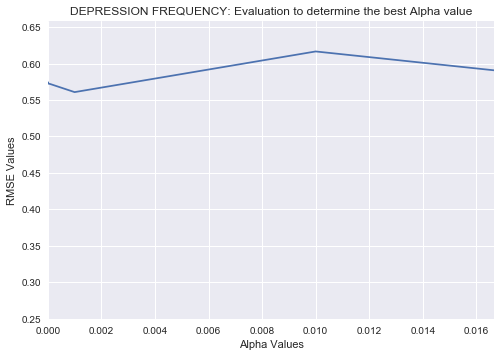

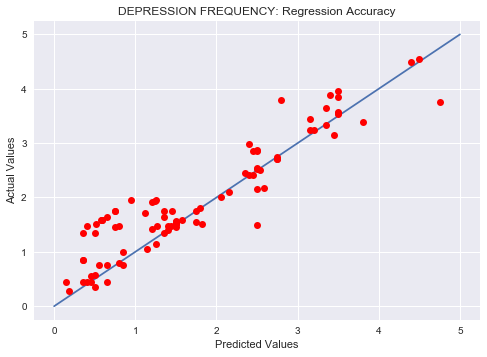

Target variable: Depression Frequency
Root Mean Squared Error: 0.267


In [109]:
'''
Implemented linear regression with lasso regularization for feature selection
'''

labels = ['Depression Frequency']
alpha = [1e-25, 1e-20, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 100]
rmse_list = [[] for i in range(len(labels))]
error = {}
score = {}

for count, label in enumerate(labels):
    
    Y = sense_df[label]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
    
    for value in alpha:
        
        # train the model for different values of alpha
        lasso_reg = Lasso(alpha=value, normalize=True, max_iter=1e6)
        lasso_reg.fit(X_train, Y_train)
        
        Y_pred = lasso_reg.predict(X_test)
                
        p_loc_start = len(Y.index) - len(Y_test)
        plot_range = [i for i in range(p_loc_start, len(Y.index))]
        
        rmse = sqrt(mean_squared_error(Y_test, Y_pred))
        
        if len(rmse_list[count]) > 0:
            if rmse < min(rmse_list[count]):
                pred_to_plot = list(Y_pred)
                test_to_plot = list(Y_test)
                error[label] = rmse
    
        rmse_list[count].append(rmse)
                
        to_plot_range = plot_range
                
    plt.title('{}: Evaluation to determine the best Alpha value'.format(label.upper()))
    plt.xlabel("Alpha Values")
    plt.ylabel("RMSE Values")
    plt.plot(alpha, rmse_list[count])
    plt.xlim(1e-25, 1e-1/6)
    plt.show()

    plt.title('{}: Regression Accuracy'.format(label.upper()))
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.plot([0,1,2,3,4,5], [0,1,2,3,4,5])
    plt.plot(pred_to_plot, test_to_plot, 'ro')    
    plt.show()
    

for label in labels:
    print('Target variable:', label)
    print('Root Mean Squared Error:', round(error[label], 4))
